# SPAN-I Field-of-View Diagnostic

Unlike SPC, the SPAN-I sensor is located behind the TPS heat shield and does not have a direct view of the sun line. That being said, when PSP approaches closer to the Sun, the speed of the spacecraft increases and so does SPAN-I's aberration angle. Therefore, there are times when SPAN-I measures the full proton VDF but we have to be a bit careful. This walkthrough is intended to teach the data user how to investigate the reliability of SPAN-I's Field-of-View (FOV). The three main culprits to check are (1) Phi angle coverage, (2) Density comparison to Quasithermal Noise (QTN), and magnetic variability.

In [3]:
import pyspedas
from pytplot import tplot, store_data, get_data ,tlimit,xlim,ylim,tplot_options,options,split_vec
from pyspedas import time_string, time_double

#import math functions 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors

First, we download data:

In [4]:
#specify time range in the form ['yyyy-mm-dd/hh:mm:ss','yyyy-mm-dd/hh:mm:ss']
trange=['2020-01-23','2020-02-03']

#specify data type to plot
datatype='spi_sf00_l3_mom' #protons
spi_vars = pyspedas.psp.spi(trange=trange, datatype=datatype, level='l3', time_clip=True)


14-Oct-22 13:32:35: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spi/l3/spi_sf00_l3_mom/2020/
14-Oct-22 13:32:36: Downloading https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spi/l3/spi_sf00_l3_mom/2020/psp_swp_spi_sf00_l3_mom_20200123_v04.cdf to psp_data/sweap/spi/l3/spi_sf00_l3_mom/2020/psp_swp_spi_sf00_l3_mom_20200123_v04.cdf
14-Oct-22 13:32:36: Download complete: psp_data/sweap/spi/l3/spi_sf00_l3_mom/2020/psp_swp_spi_sf00_l3_mom_20200123_v04.cdf
14-Oct-22 13:32:36: Downloading https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spi/l3/spi_sf00_l3_mom/2020/psp_swp_spi_sf00_l3_mom_20200124_v04.cdf to psp_data/sweap/spi/l3/spi_sf00_l3_mom/2020/psp_swp_spi_sf00_l3_mom_20200124_v04.cdf
14-Oct-22 13:32:37: Download complete: psp_data/sweap/spi/l3/spi_sf00_l3_mom/2020/psp_swp_spi_sf00_l3_mom_20200124_v04.cdf
14-Oct-22 13:32:37: Downloading https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spi/l3/spi_sf00_l3_mom/2020/psp_swp_spi_sf00_l3_mom_20200125_v04.cdf to psp_data/sweap/

## 1.) Phi Angle Coverage
The first (and perhaps most dominant) effect on SPAN-I data reliabiliy is how much the plasma is cut off by the heat shield. This is mostly in the phi direction of the instrument. To see this, we plot the energy flux in the three planes of the instrument: Energy, Theta (anode), and Phi (look direction). 

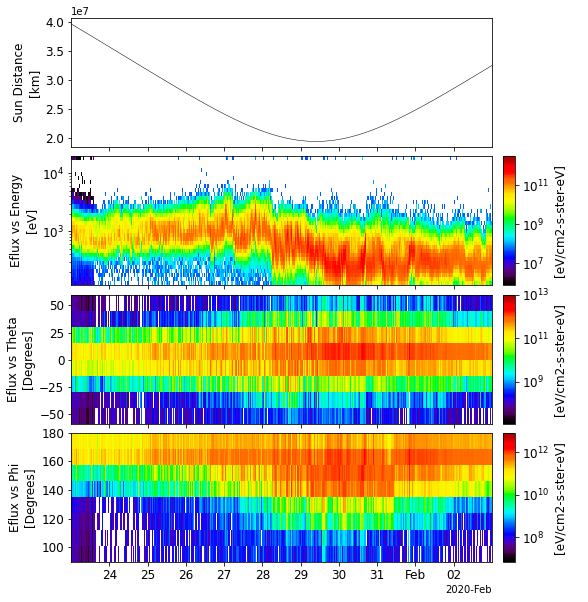

In [6]:
tplot(['psp_spi_SUN_DIST','psp_spi_EFLUX_VS_ENERGY','psp_spi_EFLUX_VS_THETA','psp_spi_EFLUX_VS_PHI'])

In the fourth panel, we see how much energy flux is captured in each phi angle bin. To determine "good" coverage by eye, one should observe that there exists a peak in the range of angles, meaning the peak (or core) of the distribution is covered in the phi measurement plane. We also want to make sure this peak is located at the 160 degree mark or lower. Note that the 180 bin will always appear to have lower flux, which may be deceptive peak

In [7]:
#define variables
eflux_phi_data=get_data('psp_spi_EFLUX_VS_PHI')
times=eflux_phi_data.times
eflux = eflux_phi_data.y
phi = eflux_phi_data.v

#determine phi angle with max eflux
max_phi_ind = np.argmax(eflux, axis=1)
max_phi = phi[0, max_phi_ind]
print(max_phi)

14-Oct-22 13:34:19: /opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



[163.125 163.125 163.125 ... 163.125 163.125 163.125]


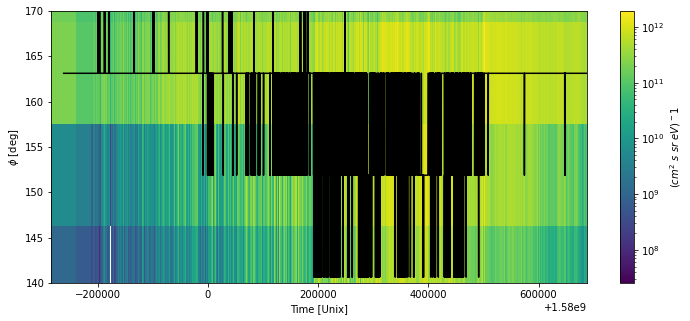

In [8]:
#epoch_something_datetime = cdflib.cdfepoch.to_datetime(cdfData_cdflib.varget('Epoch'))

fig, ax = plt.subplots(figsize=(12, 5))
p = ax.pcolormesh(times[::100], phi[0, :], eflux[::100].T, norm=matplotlib.colors.LogNorm())
plt.colorbar(p, ax=ax, label=f'$(cm^2 \\ s \\ sr \\ eV)^{-1}$')
ax.plot(times, max_phi, 'k')
ax.set(ylim=(140, 170), xlabel='Time [Unix]', ylabel=f"$\\phi$ [deg]");

In [36]:
#define fov array
tlen = times.shape[0]
phi_fov=np.ones(tlen)

#set threshold 163.125 degrees
phi_thresh = phi[0,1]

#set fov to 0, meaning reliable, if less than 163.125
for x in range(0,tlen):
    if max_phi[x] < phi_thresh:
        phi_fov[x]=0
        
print(max(phi_fov))

1.0


(128545,)


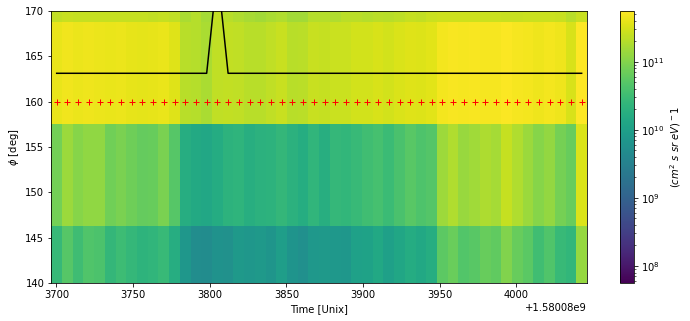

In [37]:

fig, ax = plt.subplots(figsize=(12, 5))

print(times.shape)
start_tind = 42100
stop_tind = 42150
p = ax.pcolormesh(times[start_tind:stop_tind], phi[0,:], eflux[start_tind:stop_tind].T, norm=matplotlib.colors.LogNorm())
plt.colorbar(p, ax=ax, label=f'$(cm^2 \\ s \\ sr \\ eV)^{-1}$')
ax.plot(times[start_tind:stop_tind], max_phi[start_tind:stop_tind], 'k')

ax.plot(times[start_tind:stop_tind],phi_fov[start_tind:stop_tind]*160,'r+')    
        
ax.set(ylim=(140, 170), xlabel='Time [Unix]', ylabel=f"$\\phi$ [deg]");




True

array([1.6404113e+11, 2.1004419e+11, 5.4823946e+09, 1.0807663e+09,
       1.0971808e+08, 8.9239208e+07, 1.0337610e+08, 6.5999616e+07],
      dtype=float32)

In [19]:
max_phi_ind = np.argmax(eflux, axis=1)

In [31]:
N = 100
max_phi = phi[0, max_phi_ind]
max_phi_mean = np.convolve(max_phi, np.ones(N)/N, mode='same')

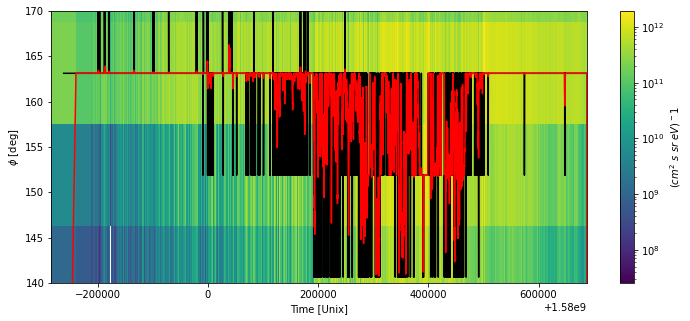

In [48]:
fig, ax = plt.subplots(figsize=(12, 5))
p = ax.pcolormesh(times[::100], phi[0, :], eflux[::100].T, norm=matplotlib.colors.LogNorm())
plt.colorbar(p, ax=ax, label=f'$(cm^2 \\ s \\ sr \\ eV)^{-1}$')
ax.plot(times, max_phi, 'k')
ax.plot(times, max_phi_mean, 'r');
ax.set(ylim=(140, 170), xlabel='Time [Unix]', ylabel=f"$\\phi$ [deg]");